In [7]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random as ra

In [9]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 1 #binary for whether it is digit or not
        
bin_digit = 6
epochs = 10            
batch_size = 64
learning_rate = 0.001
patch_size_ = [3, 7] #size range for patch in concept search

In [5]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x): #x = input img
        x = x.view(x.size(0), -1)  #flatten img, because (batch_size, 1, 28, 28) and nn.Linear expects (batch_size, features)
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [10]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [12]:
net.load_state_dict(torch.load('binary_ffn.pth')) #pre-trained

<All keys matched successfully>

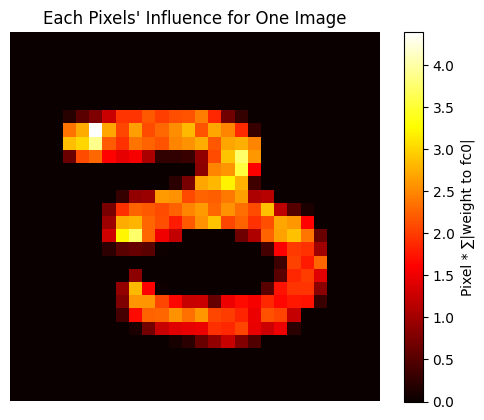

In [62]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))
img = inputs[ind].squeeze() #[28, 28]

weights = net.fc0.weight.detach().cpu() #[32, 784]
importance = weights.abs().sum(dim=0).view(28, 28) #[28, 28]

activation_fc0 = img * importance #[28, 28] 

plt.imshow(activation_fc0, cmap='hot', vmin=0, vmax=activation_fc0.max())
plt.colorbar(label='Pixel * ∑|weight to fc0|')
plt.title("Each Pixels' Influence for One Image")
plt.axis('off')
plt.show()

In [64]:
#shows that often most areas of the digit are important, but if less is needed for a correct prediciton, weights do distribute accordingly

/tmp/ipykernel_98410/2067903259.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


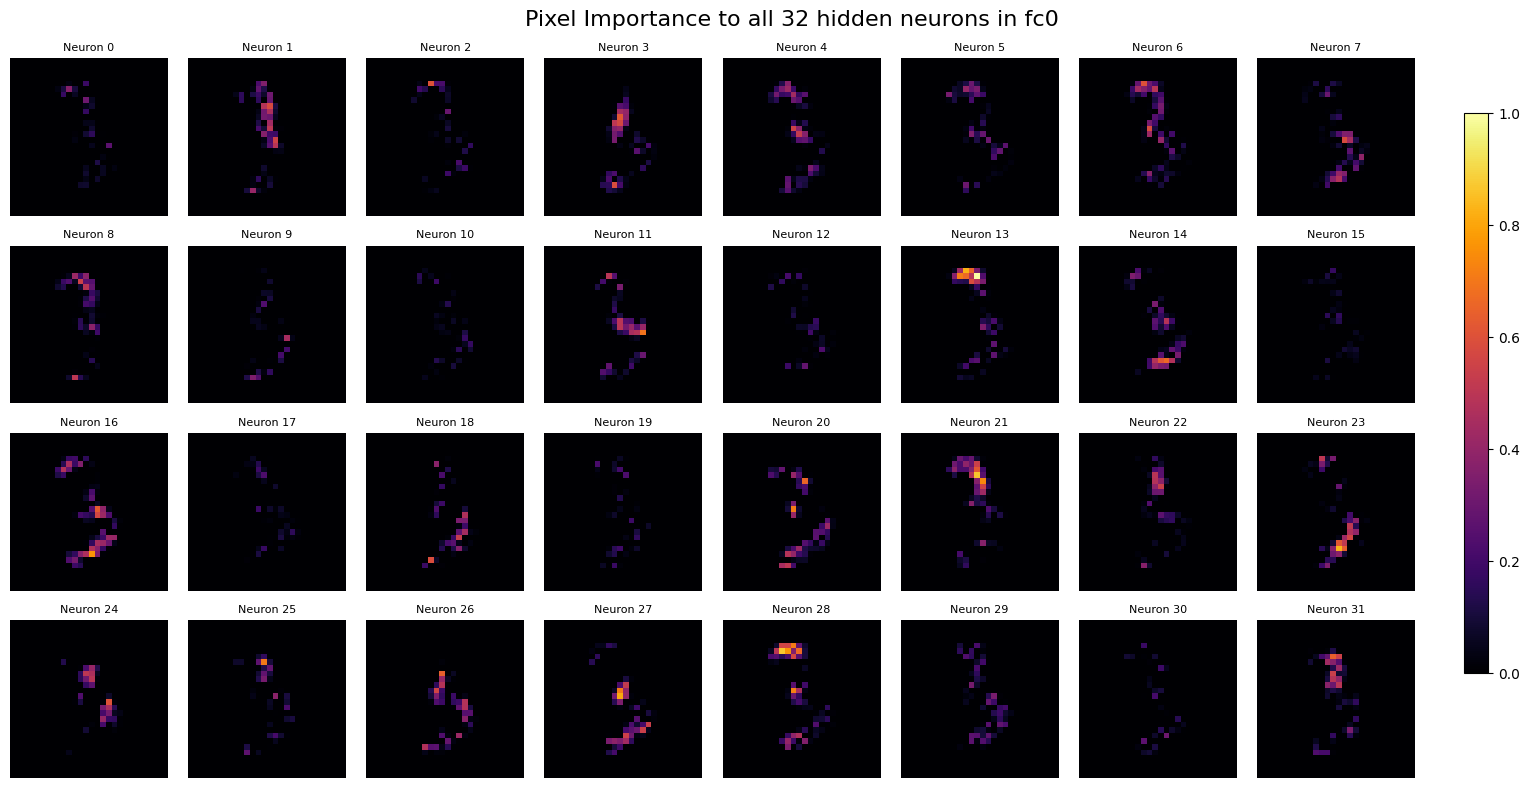

In [ ]:

inputs, labels = next(iter(test_loader))

ind = ra.randrange(0, len(inputs))
img = inputs[ind].squeeze()

img_flat = img.view(-1)

weights = net.fc0.weight.detach().cpu()
contribs = weights * img_flat #32, 784

#mask = (img_flat > 0).float()
#contribs = contribs * mask

#contribs = torch.clamp(contribs, min=0.0)

#normalise to [0, 1]
max_val = contribs.max()
contribs_norm = contribs / max_val
contribs_imgs = contribs_norm.view(-1, 28, 28)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

vmax = contribs_imgs.max().item()

for i, ax in enumerate(axes.flat):
    im = ax.imshow(contribs_imgs[i], cmap='inferno', vmin=0, vmax=vmax)
    ax.set_title(f'Neuron {i}', fontsize=8)
    ax.axis('off')

fig.suptitle('Pixel Importance to all 32 hidden neurons in fc0', fontsize=16)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [ ]:
#!NOTE TO SELF: ONCE DONE, REMOVE CERTAIN PATCHES FOR DECISIONS, TO SHOW THAT THIS PART WAS IMPORTANCE, AND USE EXAMPLE OF E.G., 3 VS 8 WHICH SHOULD BECOME HARDER THEN

In [ ]:
#next steps planned for thu: segmenter for relevant patches, make class cinstruction for concepts, make indexing system to trace activations through FFN, start summariser system to reduce FFN, check FFN accuracy with reduced paths